In [1]:
import os
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# np.set_printoptions(precision=2,suppress=True)

from osgeo import gdal,ogr,gdal_array
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
import xarray as xr

### 安装包

In [2]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
def read_raster(filename):
    dataset = gdal.Open(filename)  
    xsize = dataset.RasterXSize
    ysize = dataset.RasterYSize
   # band_count = dataset.RasterCount #统计图像波段数
    geotrans = dataset.GetGeoTransform()#获取仿射矩阵
    proj = dataset.GetProjection()  #获取地图投影信息
    #data = gdal_array.LoadFile(filename)#读取数据，numpy数组
    data = dataset.ReadAsArray(0,0,xsize,ysize)#将数据写成数组，对应栅格矩阵
    #data = dataset.ReadRaster(0,0,xsize,ysize)#将数据写成栅格数据
    del dataset
    return proj,geotrans,data


In [4]:
#自定评价函数rmse
# def root_mean_squared_error(Y_truth,Y_preds):
#     rmse=np.sqrt(mean_squared_error(Y_truth,Y_preds))
#     return rmse

# my_rmse = make_scorer(root_mean_squared_error,greater_is_better = False)

In [5]:
os.getcwd()
os.chdir("C:\\Users\\2019\\Desktop\\1a\\data")
os.getcwd()

'C:\\Users\\2019\\Desktop\\1a\\data'

In [6]:
def get_raster(filename):
    data = gdal_array.LoadFile(filename).reshape(-1,1)
    df = pd.DataFrame(data)
    del data
    return df
    

### 数据读取为narray

In [7]:
# aspect = gdal_array.LoadFile("factors/Aspect.tif").reshape(-1,1)
# elevation = gdal_array.LoadFile("factors/elevation.tif").reshape(-1,1)
# faults = gdal_array.LoadFile("factors/faults.tif").reshape(-1,1)
# landuse = gdal_array.LoadFile("factors/landuse.tif").reshape(-1,1)
# lithology = gdal_array.LoadFile("factors/lithology.tif").reshape(-1,1)
# loess = gdal_array.LoadFile("factors/Loess.tif").reshape(-1,1)
# NDVI = gdal_array.LoadFile("factors/NDVI.tif").reshape(-1,1)
# plan_curvature = gdal_array.LoadFile("factors/plan_curvature.tif").reshape(-1,1)
# profile_curvature = gdal_array.LoadFile("factors/profile_curvature.tif").reshape(-1,1)
# rainfall = gdal_array.LoadFile("factors/rainfall.tif").reshape(-1,1)
# roads = gdal_array.LoadFile("factors/raods.tif").reshape(-1,1)
# rivers = gdal_array.LoadFile("factors/rivers.tif").reshape(-1,1)
# slope = gdal_array.LoadFile("factors/slope_angle.tif").reshape(-1,1)
# twi = gdal_array.LoadFile("factors/TWI.tif").reshape(-1,1)
# spi = gdal_array.LoadFile("factors/SPI.tif").reshape(-1,1)
# landslides = gdal_array.LoadFile("factors/landslide.tif").reshape(-1,1)

In [8]:
# print('行数, 列数',twi.shape)
# print('栅格数',twi.size)
# print('数组维度',twi.ndim)
# print('数组长度',len(twi))#返回行数
# print('数组中元素的数据类型',twi.dtype)
# print('数据类型名',twi.dtype.name)
# #np.info(np.ndarry.dtype)帮助

### 数据读取为df

In [9]:
aspect = get_raster("factors/Aspect.tif")
elevation = get_raster("factors/elevation.tif")
faults = get_raster("factors/faults.tif")
landuse = get_raster("factors/landuse.tif")
lithology = get_raster("factors/lithology.tif")
loess = get_raster("factors/Loess.tif")
NDVI = get_raster("factors/NDVI.tif")
plan_curvature = get_raster("factors/plan_curvature.tif")
profile_curvature = get_raster("factors/profile_curvature.tif")
rainfall = get_raster("factors/rainfall.tif")
roads = get_raster("factors/raods.tif")
rivers = get_raster("factors/rivers.tif")
slope = get_raster("factors/slope_angle.tif")
twi = get_raster("factors/TWI.tif")
spi = get_raster("factors/SPI.tif")
landslides = get_raster("factors/landslide.tif")

In [10]:
aspect.rename(columns={0:'aspect'},inplace=True)
elevation.rename(columns={0:'elevation'},inplace=True)
faults.rename(columns={0:'faults'},inplace=True)
landuse.rename(columns={0:'landuse'},inplace=True)
lithology.rename(columns={0:'lithology'},inplace=True)
loess.rename(columns={0:'loess'},inplace=True)
NDVI.rename(columns={0:'NDVI'},inplace=True)
plan_curvature.rename(columns={0:'plan_curvature'},inplace=True)
profile_curvature.rename(columns={0:'profile_curvature'},inplace=True)
rainfall.rename(columns={0:'rainfall'},inplace=True)
roads.rename(columns={0:'roads'},inplace=True)
rivers.rename(columns={0:'rivers'},inplace=True)
slope.rename(columns={0:'slope'},inplace=True)
twi.rename(columns={0:'twi'},inplace=True)
spi.rename(columns={0:'spi'},inplace=True)
landslides.rename(columns={0:'landslides'},inplace=True)

In [11]:
print('行数, 列数',twi.shape)
print('栅格数',twi.size)
print('数组维度',twi.ndim)
print('数组长度',len(twi))#返回行数
# print('数组中元素的数据类型',twi.dtype)
# print('数据类型名',twi.dtype.name)
#np.info(np.ndarry.dtype)帮助

行数, 列数 (14654529, 1)
栅格数 14654529
数组维度 2
数组长度 14654529


In [12]:
# np.argwhere(np.isnan(aspect))#找空值所在行

### 栅格数据合并，空值填充

In [13]:
# # #narry合并
# pred_data=np.column_stack((aspect,elevation,faults,landuse,lithology,loess,NDVI,plan_curvature,profile_curvature,rainfall,roads,rivers,slope,twi,spi,landslides))
# # pred_data = np.hstack((aspect,elevation,faults,landuse,lithology,loess,NDVI,plan_curvature,profile_curvature,rainfall,roads,rivers,slope,twi,spi,landslides))
# pred_data

In [14]:
# df合并
pred_data = pd.concat([aspect,elevation,faults,landuse,lithology,loess,NDVI,plan_curvature,\
    profile_curvature,rainfall,roads,rivers,slope,twi,spi,landslides],axis=1)

pred_data.head(2)


,aspect,elevation,faults,landuse,lithology,loess,NDVI,plan_curvature,profile_curvature,rainfall,roads,rivers,slope,twi,spi,landslides
0,-3.402823e+38,-999,-3.402823e+38,15,255,255,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,127
1,-3.402823e+38,-999,-3.402823e+38,15,255,255,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,127


In [15]:
#删除变量，释放内存
del aspect,elevation,faults,landuse,lithology,loess,NDVI,plan_curvature,\
    profile_curvature,rainfall,roads,rivers,slope,twi,spi,landslides

In [16]:
#df检查空值并填充
null_value_stats = pred_data.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]
# pred_data.fillna(-999, inplace=True)

#narray检查空值
# np.argwhere(np.isnan(pred_data))#找空值所在行

Series([], dtype: int64)

## 读取矢量数据

In [17]:
#读取矢量数据
landslide_shp_df = geopandas.GeoDataFrame.from_file("QGIS_Values/landslide.shp")
unlandslide_shp_df = geopandas.GeoDataFrame.from_file("QGIS_Values/unlandslide.shp")
# landslide_shp_df.head(2),unlandslide_shp_df.head(2)


### 列名更新

In [18]:
#换列名
landslide_shp_df.rename(columns={'plan_curva':'plan_curvature','profile_cu':'profile_curvature','raods':'roads'},inplace=True)
unlandslide_shp_df.rename(columns={'plan_curva':'plan_curvature','profile_cu':'profile_curvature','raods':'roads'},inplace=True)

### 数据合并

In [19]:
#合并
data = pd.concat([landslide_shp_df,unlandslide_shp_df])

del landslide_shp_df,unlandslide_shp_df

### 检查空值

In [20]:
#检查空值
null_value_stats = data.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

twi    1
dtype: int64

### 空值填充

In [21]:
# data.fillna(-999, inplace=True)

### 变量类型z转换
    int转换为string

In [22]:
data['landuse'] = data['landuse'].apply(str)
data['lithology'] = data['lithology'].apply(str)
data['loess'] = data['loess'].apply(str)
data.dtypes

aspect                float64
elevation             float64
faults                float64
landuse                object
lithology              object
loess                  object
NDVI                  float64
plan_curvature        float64
profile_curvature     float64
rainfall              float64
roads                 float64
rivers                float64
slope                 float64
twi                   float64
spi                   float64
landslides            float64
geometry             geometry
dtype: object

### 数据集划分

In [23]:
#划分数据集
colName= ['aspect','elevation','faults','landuse','lithology','loess','NDVI',\
          'plan_curvature','profile_curvature','rainfall','roads','rivers','slope','twi','spi']
#非滑坡
x_train1, x_test1, y_train1, y_test1 = train_test_split(data[data["landslides"]==0][colName],data[data["landslides"]==0]["landslides"],\
                                                   test_size=0.3,random_state=10)
#滑坡
x_train2, x_test2, y_train2, y_test2 = train_test_split(data[data["landslides"]!=0][colName],data[data["landslides"]!=0]["landslides"],\
                                                   test_size=0.3,random_state=11)

x_train = pd.concat([x_train1,x_train2])
y_train = pd.concat([y_train1,y_train2])
x_test = pd.concat([x_test1,x_test2])
y_test = pd.concat([y_test1,y_test2])
del x_train1,x_test1,y_train1, y_test1,x_train2, x_test2, y_train2, y_test2,data

### CatBoost模型

找出分类变量

In [24]:
categorical_features_indices = np.where(x_train.dtypes != np.float)[0]

设置模型参数

In [25]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 1,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)

In [26]:
model = CatBoostClassifier(**params)
model.fit(train_pool,eval_set=test_pool)


In [28]:
best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True,
    'random_seed':2
})

best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=test_pool);

print('Simple model validation accuracy: {:.4}'.format(accuracy_score(y_test, model.predict(x_test))))
print('')
print('Best model validation accuracy: {:.4}'.format(accuracy_score(y_test, best_model.predict(x_test))))


Simple model validation accuracy: 0.8604

Best model validation accuracy: 0.8734


In [32]:
eval_metrics = model.eval_metrics(train_pool, ['AUC'], plot=True)
np.max(eval_metrics)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'AUC': [0.9055741081739022,
  0.9392887238226023,
  0.9415124371898504,
  0.941020879498143,
  0.9470249055897132,
  0.9500834867825598,
  0.9546947660809588,
  0.9552916575637465,
  0.9550809899815861,
  0.9546635560687868,
  0.9560328953528292,
  0.9561733404076027,
  0.9569613932149433,
  0.9568638619269062,
  0.9573086046003558,
  0.957893792328579,
  0.9582605099715988,
  0.9594347866795668,
  0.959723479292157,
  0.9618535626228895,
  0.9640850784931806,
  0.9650837988826816,
  0.9650681938765956,
  0.9655597515683031,
  0.9665272619456322,
  0.9675103773290472,
  0.9677600574264223,
  0.9679785275116257,
  0.9678770949720671,
  0.968563715239849,
  0.9693907805624045,
  0.9702958709153897,
  0.9710215036983865,
  0.9714428388627071,
  0.9716144939296526,
  0.9722074841609188,
  0.9723557317187353,
  0.9733778596173652,
  0.9734012671264942,
  0.9736977622421272,
  0.974111294903405,
  0.9743219624855654,
  0.9746106550981555,
  0.9752270528385506,
  0.9752270528385506,
  0.9765

In [33]:
eval_metrics = model.eval_metrics(test_pool, ['AUC'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:

feature_importances = model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

elevation: 26.388978437058682
roads: 8.59742505602988
slope: 8.549541880688254
profile_curvature: 7.364026894223935
faults: 6.418362563901618
spi: 5.797030580281749
aspect: 5.497796524233558
NDVI: 5.488017302653521
rainfall: 5.143050390819738
twi: 4.92000630377692
plan_curvature: 4.331553490182201
rivers: 3.9862877063431905
landuse: 3.272708569794379
loess: 2.2090918599772147
lithology: 2.0361224400351565


### 构建Pool

In [35]:
pred_data['landuse'] = pred_data['landuse'].apply(str)
pred_data['lithology'] = pred_data['lithology'].apply(str)
pred_data['loess'] = pred_data['loess'].apply(str)
pred_data.dtypes


aspect               float32
elevation              int16
faults               float32
landuse               object
lithology             object
loess                 object
NDVI                 float32
plan_curvature       float32
profile_curvature    float32
rainfall             float32
roads                float32
rivers               float32
slope                float32
twi                  float32
spi                  float32
landslides              int8
dtype: object

In [36]:
pred_pool = Pool(data=pred_data[colName], label=pred_data['landslides'], cat_features=categorical_features_indices)

### 模型应用

In [37]:
predictions_pred = model.predict(pred_pool)
predictions_probs_pred = model.predict_proba(pred_pool)
print(predictions_pred)
print(predictions_probs_pred)

[0. 0. 0. ... 0. 0. 0.]
[[0.96945943 0.03054057]
 [0.96945943 0.03054057]
 [0.96945943 0.03054057]
 ...
 [0.96945943 0.03054057]
 [0.96945943 0.03054057]
 [0.96945943 0.03054057]]


In [38]:
#x写出栅格
dataset = gdal.Open('factors/NDVI.tif')
xsize=dataset.RasterXSize
ysize = dataset.RasterYSize
proj = dataset.GetProjection()  #获取地图投影信息
geotrans = dataset.GetGeoTransform()
NDVI_data = dataset.ReadAsArray(0,0,xsize,ysize)

In [39]:
driver = gdal.GetDriverByName("GTiff")
dst_ds = driver.Create('catboost_result.tif',xsize,ysize,bands=1,eType=gdal.GDT_Float32)
dst_ds.SetGeoTransform(geotrans)
dst_ds.SetProjection(proj)
raster = predictions_probs_pred[:,1].reshape(ysize,xsize)
raster = np.around(raster, decimals=3, out=None)
raster.astype(np.float32)


array([[0.031, 0.031, 0.031, ..., 0.031, 0.031, 0.031],
       [0.031, 0.031, 0.031, ..., 0.031, 0.031, 0.031],
       [0.031, 0.031, 0.031, ..., 0.031, 0.031, 0.031],
       ...,
       [0.031, 0.031, 0.031, ..., 0.031, 0.031, 0.031],
       [0.031, 0.031, 0.031, ..., 0.031, 0.031, 0.031],
       [0.031, 0.031, 0.031, ..., 0.031, 0.031, 0.031]], dtype=float32)

### 写出栅格

In [ ]:
dst_ds.GetRasterBand(1).WriteArray(raster)
dst_ds.FlushCache()
del dst_ds

In [ ]:
#裁剪
#cropToCutline不设置时，裁减后图像大小与原图相同，但裁剪外的像素值为nodata或0
gdal.Warp("catboost_result.tif",dataset,cutlineDSName="data/xinyuan/xinyuan.shp")#,cropToCutline=True)
 

### 绘制地图

In [40]:
from mpl_toolkits.basemap import Basemap

import numpy as np
from osgeo import gdal
import cartopy.crs as ccrs
import shapefile
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER

In [41]:
def basemask(cs, ax, map, shpfile):
    sf = shapefile.Reader(shpfile)
    vertices = []
    codes = []
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] >= 0:  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                for j in range(prt[i], prt[i+1]):
                    vertices.append(map(pts[j][0], pts[j][1]))
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
                codes += [Path.CLOSEPOLY]
            clip = Path(vertices, codes)
            clip = PathPatch(clip, transform = ax.transData)
#     for contour in cs.collections:
#         contour.set_clip_path(clip) 
    cs.set_clip_path(clip) #我的shp文件只包含一个区域，包含多个区域就用上面
            
def makedegreelabel(degreelist):
    labels = [str(x)+u'°E' for x in degreelist ]
    return labels



In [42]:
import rasterio
ds = xr.open_rasterio('C:/Users/2019/Desktop/1a/data/catboost_result_wgs84.tif')
lat = ds.y
lon = ds.x
data = ds.data

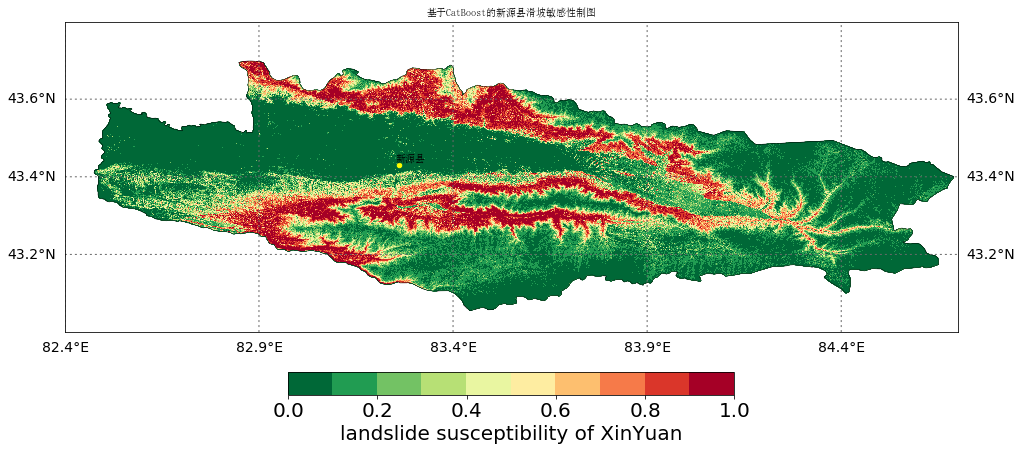

In [43]:
#设置宋体
ZHfont = matplotlib.font_manager.FontProperties(fname='/Users/2019/Documents/fonts/SimSun.ttf')

#[west ,east,south,north]
m = Basemap(llcrnrlon=82.4,
           llcrnrlat=43.0,
           urcrnrlon=84.7,
           urcrnrlat=43.8,
           resolution=None,
           projection='cyl')
#颜色条
cbar_kwargs={
    'orientation':'horizontal',
#     'orientation':'vertical',
    'label':'landslide susceptibility of XinYuan',
    'shrink':0.5,
    'ticks':np.arange(0,1.1,0.2),
    'pad':-0.45,#控制颜色条和图的距离
    'shrink':0.5,
#     "spacing": "proportional"
}


#设置绘图字体
plt.rcParams.update({'font.size':20})
fig = plt.figure(figsize=[16,18])#设置图片大小
ax = fig.add_subplot(111)

os.chdir('C:/Users/2019/Desktop/1a/data')
levels = np.arange(0,1.1,0.1)

cs = ds.plot(ax=ax,levels=levels,cbar_kwargs=cbar_kwargs, cmap='RdYlGn_r')#RdYlGn
m.readshapefile('xinyuan/xinyuan_wgs84','xinyuan_wgs84')
basemask(cs, ax, m, 'xinyuan/xinyuan_wgs84') 


parallels = np.arange(43.2,44+1,0.2)
m.drawparallels(parallels,labels=[True,True,True,True],color='dimgrey',dashes=[2, 3],fontsize= 14)  # ha= 'right'
meridians = np.arange(82.4,85+1,0.5)
m.drawmeridians(meridians,labels=[True,True,False,True],color='dimgrey',dashes=[2, 3],fontsize= 14)

plt.ylabel('')
plt.xlabel('')

plt.rcParams.update({'font.size':25})
ax.set_title(u'基于CatBoost的新源县滑坡敏感性制图',color='black',fontsize= 25 ,fontproperties=ZHfont)


# 43.4299° N, 83.2608° E 新源县
lat0 = 43.4299
lon0 = 83.2608
plt.scatter(lon0,lat0,marker='.',s=80,color='yellow',zorder=2)

# # 43.3286° N, 84.0040° E那拉提镇
# lat1=43.3286
# lon1=84.0040
# plt.scatter(lon1,lat1,marker='.',s=120,color='yellow',zorder=2)

plt.rcParams.update({'font.size':18})
plt.text(lon0-0.01, lat0+0.01, u"新源县",fontsize= 18 ,color ="black",fontproperties=ZHfont)
# plt.text(lon1-0.01, lat1+0.01, u"那拉提镇" ,fontsize= 18 ,color ="r",fontproperties=ZHfont)

# # Save & Show figure
plt.savefig("Catboost result.tif", dpi=300, bbox_inches='tight')
plt.show()